In [ ]:
!pip install -q pandas openpyxl scikit-learn tensorflow keras xgboost tqdm
from google.colab import output
output.clear()
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import xgboost as xgb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import drive
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
DRIVE_PROJECT_DIR = '/content/drive/My Drive/AI_Resource_Optimizer'
os.makedirs(DRIVE_PROJECT_DIR, exist_ok=True)

SOLAR_MODEL_PATH = '/content/drive/My Drive/SolarForecast_Project_Final/cnn_lstm_attention_model.keras'
RESERVOIR_DATA_PATH = '/content/drive/My Drive/ReservoirAdvisor_Project_Final/ReservoirData/data.xlsx'

IEX_RAW_DATA_DIR = os.path.join(DRIVE_PROJECT_DIR, "IEX_Price_Data") #<-- YOUR PATH
os.makedirs(IEX_RAW_DATA_DIR, exist_ok=True)

IEX_COMBINED_CLEAN_PATH = os.path.join(DRIVE_PROJECT_DIR, "IEX_Price_Data_Combined_Clean.csv")
MASTER_DATA_PATH = os.path.join(DRIVE_PROJECT_DIR, "Master_Indian_Data_Final.csv")
PRICE_MODEL_PATH = os.path.join(DRIVE_PROJECT_DIR, "price_forecaster_final.json")

print("\n✅ Final environment is ready.")
print(f"!!! ENSURING YOUR 24 CLEANED .csv FILES ARE IN THIS DIRECTORY: {IEX_RAW_DATA_DIR} !!!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Final environment is ready.
!!! ENSURING YOUR 24 CLEANED .csv FILES ARE IN THIS DIRECTORY: /content/drive/My Drive/AI_Resource_Optimizer/IEX_Price_Data !!!


In [ ]:
if os.path.exists(IEX_COMBINED_CLEAN_PATH):
    print("✅ Found cached combined IEX price data. Skipping processing.")
else:
    print("⏳ Processing your clean IEX CSV files from your specified directory...")

    # This check now points to your specified RAW data directory
    if not os.path.exists(IEX_RAW_DATA_DIR) or len(os.listdir(IEX_RAW_DATA_DIR)) == 0:
        raise FileNotFoundError(f"Directory is empty: '{IEX_RAW_DATA_DIR}'. Please upload your 24 CSV files.")

    all_monthly_dfs = []

    import re
    def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
        return [int(text) if text.isdigit() else text.lower() for text in _nsre.split(s)]

    csv_files = sorted([f for f in os.listdir(IEX_RAW_DATA_DIR) if f.endswith('.csv')], key=natural_sort_key)
    print(f"Found {len(csv_files)} clean monthly CSV files to process.")

    for filename in tqdm(csv_files, desc="Processing CSV Files"):
        try:
            temp_df = pd.read_csv(os.path.join(IEX_RAW_DATA_DIR, filename))

            temp_df.columns = temp_df.columns.str.strip().str.replace(' \*', '', regex=True)

            temp_df = temp_df[['Date', 'Hour', 'MCP (Rs/MWh)']]
            temp_df.columns = ['date_str', 'hour', 'price_mwh']

            temp_df.dropna(how='all', inplace=True)

            temp_df['datetime'] = pd.to_datetime(temp_df['date_str'], dayfirst=True) + \
                                  pd.to_timedelta(temp_df['hour'].astype(int) - 1, unit='h')
            temp_df['price_mwh'] = pd.to_numeric(temp_df['price_mwh'], errors='coerce')

            all_monthly_dfs.append(temp_df[['datetime', 'price_mwh']])
        except Exception as e:
            print(f"\nERROR processing file {filename}. Error: {e}")

    if not all_monthly_dfs: raise ValueError("CRITICAL ERROR: No data was processed from your CSV files.")

    df_price = pd.concat(all_monthly_dfs, ignore_index=True)
    df_price.dropna(inplace=True)
    df_price.set_index('datetime', inplace=True)
    df_price.sort_index(inplace=True)
    df_price = df_price[~df_price.index.duplicated(keep='first')]

    df_price.to_csv(IEX_COMBINED_CLEAN_PATH)
    print("\n✅ Your clean IEX csv files have been processed and combined into a single file.")

df_price_check = pd.read_csv(IEX_COMBINED_CLEAN_PATH)
print("\n--- Verification of Combined Price Data ---")
df_price_check.info()

✅ Found cached combined IEX price data. Skipping processing.

--- Verification of Combined Price Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   17544 non-null  object 
 1   price_mwh  17544 non-null  float64
dtypes: float64(1), object(1)
memory usage: 274.3+ KB


In [ ]:
print("⏳ Creating Master dataset...")
if os.path.exists(MASTER_DATA_PATH):
     print("✅ Found cached Master dataset.")
else:
    # This cell will now correctly load the clean data from the new Cell 2
    df_price = pd.read_csv(IEX_COMBINED_CLEAN_PATH, parse_dates=['datetime'], index_col='datetime')
    df_res_raw = pd.read_excel(RESERVOIR_DATA_PATH)

    df_res_raw.columns = df_res_raw.columns.str.strip()
    df_res = pd.DataFrame()
    df_res['datetime'] = pd.to_datetime(df_res_raw['Date'])
    df_res['storage_mcm'] = pd.to_numeric(df_res_raw['Current Live Storage'], errors='coerce')
    df_res.set_index('datetime', inplace=True); df_res.dropna(inplace=True); df_res.sort_index(inplace=True)
    df_res_hourly = df_res.resample('h').ffill()

    df_master = df_price.join(df_res_hourly, how='inner')
    df_master.dropna(inplace=True)

    df_master['hour'] = df_master.index.hour
    df_master['day_of_week'] = df_master.index.dayofweek
    df_master['month'] = df_master.index.month
    df_master['price_lag_24h'] = df_master['price_mwh'].shift(24)
    df_master.dropna(inplace=True)

    df_master.to_csv(MASTER_DATA_PATH)
    print("✅ Master Indian dataset created and cached.")

df_master_check = pd.read_csv(MASTER_DATA_PATH, parse_dates=['datetime'])
print("\n--- Verification of Master Data ---")
df_master_check.info()

⏳ Creating Master dataset...
✅ Found cached Master dataset.

--- Verification of Master Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       17520 non-null  datetime64[ns]
 1   price_mwh      17520 non-null  float64       
 2   storage_mcm    17520 non-null  float64       
 3   hour           17520 non-null  int64         
 4   day_of_week    17520 non-null  int64         
 5   month          17520 non-null  int64         
 6   price_lag_24h  17520 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 958.3 KB


⏳ Loading master data and training the XGBoost Price Forecaster...

--- Starting Model Training ---
✅ Price Forecaster model trained and saved.

--- Visualizing a Sample Price Forecast ---


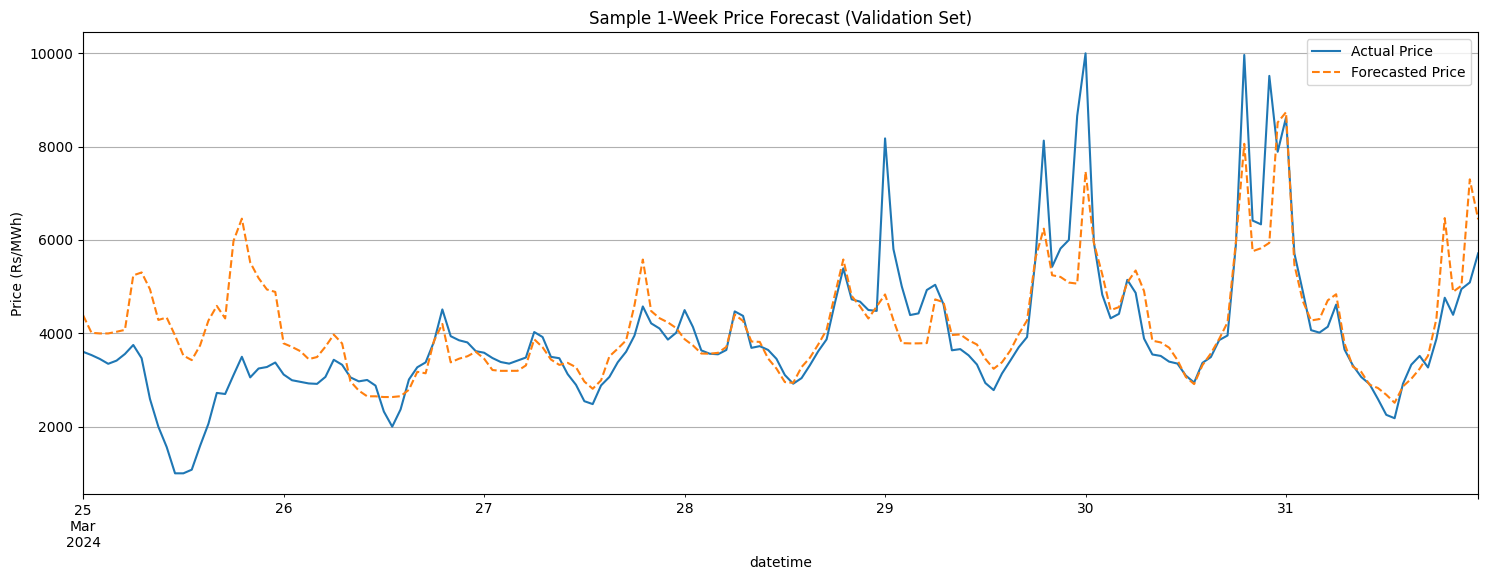

In [ ]:
print("⏳ Loading master data and training the XGBoost Price Forecaster...")

df_master = pd.read_csv(MASTER_DATA_PATH, parse_dates=['datetime'], index_col='datetime')
target = 'price_mwh'

features = [
    'storage_mcm',
    'hour',
    'day_of_week',
    'month',
    'price_lag_24h'
]

X = df_master[features].astype('float32')
y = df_master[target]

split_index = int(len(X) * 0.8)
X_train, X_val, y_train, y_val = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]

model_price_forecaster = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=15,
    eval_metric='rmse'
)

print("\n--- Starting Model Training ---")
model_price_forecaster.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

model_price_forecaster.save_model(PRICE_MODEL_PATH)
print(f"✅ Price Forecaster model trained and saved.")

print("\n--- Visualizing a Sample Price Forecast ---")
preds = model_price_forecaster.predict(X_val)
sample_period = y_val.tail(24 * 7)
sample_preds = pd.Series(preds, index=y_val.index).tail(24 * 7)
plt.figure(figsize=(18, 6)); sample_period.plot(label='Actual Price'); sample_preds.plot(label='Forecasted Price', linestyle='--')
plt.title("Sample 1-Week Price Forecast (Validation Set)")
plt.ylabel("Price (Rs/MWh)")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
print("🚀 Loading all AI assets and building the Optimization Advisor logic...")

try:
    solar_model = load_model(SOLAR_MODEL_PATH)
    price_model = xgb.XGBRegressor()
    price_model.load_model(PRICE_MODEL_PATH)
    df_master = pd.read_csv(MASTER_DATA_PATH, parse_dates=['datetime'], index_col='datetime')
    print("✅ All AI models and master data loaded successfully.")
except Exception as e:
    raise FileNotFoundError(f"FATAL: A required asset is missing. Ensure all previous notebooks and cells ran successfully. Details: {e}")

def get_optimal_schedule(solar_forecast, price_forecast, initial_storage, max_storage, flood_level_pct, drought_level_pct, max_release_per_hour, mwh_per_mcm):

    schedule, actions, storage_trace = [], [], [initial_storage]
    current_storage = initial_storage
    flood_level_mcm = max_storage * flood_level_pct
    drought_level_mcm = max_storage * drought_level_pct

    for i in range(24):
        price_now = price_forecast[i]
        solar_now = solar_forecast[i]

        # Rule 1: Safety First (Flood Prevention)
        if current_storage > flood_level_mcm:
            action, release = "GENERATE_MAX_FLOOD", max_release_per_hour

        # Rule 2: Profit Maximization (Arbitrage)
        # Generate hydropower when the price is high and free solar energy is unavailable.
        elif price_now > np.percentile(price_forecast, 75) and (solar_forecast.max() == 0 or solar_now < (solar_forecast.max() * 0.1)):
            action, release = "GENERATE_PEAK", max_release_per_hour

        # Rule 3: Resource Synergy (Store Solar as Water)
        # When solar power is abundant (and prices are likely low), conserve water.
        elif solar_now > np.percentile(solar_forecast, 75) and current_storage < flood_level_mcm:
            action, release = "HOLD_STORE", 0

        # Rule 4: Baseload Generation
        # If the price is moderately good, generate some power.
        elif price_now > np.percentile(price_forecast, 50):
            action, release = "GENERATE_BASE", max_release_per_hour / 2

        # Rule 5: Default is to Conserve
        else:
            action, release = "HOLD_CONSERVE", 0

        # Rule 6: Safety First (Drought Prevention)
        # Override any non-emergency generation if it violates drought levels.
        if current_storage - release < drought_level_mcm:
            release = max(0, current_storage - drought_level_mcm)
            if action not in ["GENERATE_MAX_FLOOD"]:
                action = "HOLD_DROUGHT_RISK"

        current_storage -= release
        actions.append(action)
        schedule.append(release)
        storage_trace.append(current_storage)

    hydropower_mwh = np.array(schedule) * mwh_per_mcm
    revenue = np.sum(hydropower_mwh * price_forecast)

    return actions, hydropower_mwh, revenue, np.array(storage_trace)

print("\n✅ Optimization logic and decision-making engine are ready.")

🚀 Loading all AI assets and building the Optimization Advisor logic...
✅ All AI models and master data loaded successfully.

✅ Optimization logic and decision-making engine are ready.


In [ ]:
print("🚀 Launching the AI Hydro-Solar Nexus Arbitrageur Dashboard...")

weather_selector = widgets.Dropdown(
    options=["Clear Sunny Day", "Intermittent Clouds", "Heavy Monsoon Day"],
    description='Weather Scenario:',
    style={'description_width': 'initial'}
)
storage_selector = widgets.IntSlider(
    min=10, max=100, step=5, value=75,
    description='Initial Reservoir Level (%):',
    style={'description_width': 'initial'}
)

def run_simulation(weather_scenario, initial_storage_percent):

    # --- Step 1 & 2: Simulate Solar and Price Forecasts ---
    if weather_scenario == "Clear Sunny Day":
        solar_kw = 80000 * (np.sin(np.linspace(0, np.pi, 24) - 0.2)**2)
    elif weather_scenario == "Intermittent Clouds":
        solar_kw = 80000 * (np.sin(np.linspace(0, np.pi, 24) - 0.2)**2) * np.random.uniform(0.5, 1, 24)
    else: # Heavy Monsoon
        solar_kw = 15000 * (np.sin(np.linspace(0, np.pi, 24) - 0.2)**2)
    solar_mwh = np.clip(solar_kw / 1000, 0, None)

    last_day_features = df_master[price_model.feature_names_in_].tail(24)
    price_forecast = price_model.predict(last_day_features)

    max_storage = df_master['storage_mcm'].max()
    initial_storage = (initial_storage_percent / 100) * max_storage
    actions, hydro_mwh, revenue, storage_trace = get_optimal_schedule(
        solar_forecast=solar_mwh, price_forecast=price_forecast, initial_storage=initial_storage,
        max_storage=max_storage, flood_level_pct=0.9, drought_level_pct=0.3,
        max_release_per_hour=max_storage*0.05, mwh_per_mcm=150
    )

    print(f"\n--- OPTIMAL 24-HOUR SCHEDULE ---")
    print(f"Projected Hydropower Revenue: ₹ {revenue:,.0f}")

    fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True, gridspec_kw={'height_ratios': [2, 3, 1.5]})
    hours = np.arange(24)

    axes[0].plot(hours, price_forecast, label='Forecasted Price (Rs/MWh)', color='red', marker='o')
    axes[0].plot(hours, solar_mwh, label='Simulated Solar (MWh)', color='orange', marker='s')
    axes[0].set_title('Forecasted Market & Weather Conditions', fontsize=16); axes[0].set_ylabel('Price / Power')
    axes[0].legend(); axes[0].grid(True)

    ax1b = axes[1].twinx()
    axes[1].bar(hours, hydro_mwh, label='Hydropower Schedule (MWh)', color='dodgerblue', alpha=0.7)
    ax1b.plot(np.arange(25), storage_trace / max_storage * 100, label='Reservoir Level (%)', color='green', linestyle='--')
    axes[1].set_title('Prescriptive AI Hydropower & Storage Schedule', fontsize=16); axes[1].set_ylabel('Generation (MWh)')
    ax1b.set_ylabel('Reservoir Level (%)'); ax1b.set_ylim(0, 110); axes[1].legend(loc='upper left'); ax1b.legend(loc='upper right'); axes[1].grid(True)

    axes[2].bar(hours, actions, label='Actions', color='purple')
    axes[2].set_title('Operational Action Plan', fontsize=16); axes[2].set_ylabel('Action'); axes[2].set_xlabel('Hour of the Day')
    axes[2].set_xticks(hours); axes[2].tick_params(axis='x', rotation=90); axes[2].grid(axis='y')

    plt.tight_layout(); plt.show()

out = widgets.interactive_output(run_simulation, {'weather_scenario': weather_selector, 'initial_storage_percent': storage_selector})
display(widgets.HBox([weather_selector, storage_selector]), out)

🚀 Launching the AI Hydro-Solar Nexus Arbitrageur Dashboard...


Output()